In [1]:
# download from source
# !pip install sktime[dl]

# download from fork (because 2 PRs are not merged yet)
# !pip install git+https://github.com/geetu040/sktime.git@gsoc-submission

In [2]:
# import functions
from sktime.datasets import (
	load_airline,
	load_unit_test,
)
from sktime.utils.plotting import plot_series
from sktime.utils._testing.hierarchical import _make_hierarchical
from sklearn.model_selection import train_test_split

# to avoid jax runtime errors
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["JAX_PLATFORMS"] = "cpu"

# to avoid unwanted lengthy warnings
import warnings
warnings.filterwarnings("ignore")

# Overview

List of all estimators, authored or co-authored by me

In [3]:
from sktime.registry import all_estimators

all_estimators(
    filter_tags={"authors": "geetu040"},
    return_tags=['capability:global_forecasting', 'ignores-exogeneous-X'],
	return_names=True, as_dataframe=True, suppress_import_stdout=True
)

2024-08-23 23:44:55.843500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-23 23:44:55.843546: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


,name,object,capability:global_forecasting,ignores-exogeneous-X
0,AutoRegressiveWrapper,<class 'sktime.forecasting.compose._autoregres...,True,False
1,DummyGlobalForecaster,<class 'sktime.forecasting.dummy.DummyGlobalFo...,True,False
2,LTSFTransformerForecaster,<class 'sktime.forecasting.ltsf.LTSFTransforme...,None,True
3,MVTSTransformerClassifier,<class 'sktime.classification.deep_learning.mv...,None,None
4,NeuralForecastRNN,<class 'sktime.forecasting.neuralforecast.Neur...,None,False
5,TimesFMForecaster,<class 'sktime.forecasting.timesfm_forecaster....,True,True
6,TinyTimeMixerForecaster,<class 'sktime.forecasting.ttm.TinyTimeMixerFo...,True,True


# AutoRegressiveWrapper

- **Title:** [ENH] Implement Autoregressive Wrapper
- **Status:** Open
- **Pull Request:** [#6842](https://github.com/sktime/sktime/pull/6842)
- **Related Issue:** [#6802](https://github.com/sktime/sktime/issues/6802)

In sktime, some global forecasters require the forecasting horizon to be specified during the fitting process, limiting their ability to predict on different horizons afterward. This pull request introduces the `AutoregressiveWrapper`, which wraps around these forecasters, allowing them to forecast on varying horizons while fitting on a fixed horizon that is generated internally.

During this implementation, I deepened my understanding of pandas indexes, particularly in handling multi-indexes. By the end of the process, I was able to create efficient and reliable code.

In [4]:
y = load_airline()

First, we load a forecaster that requires forecasting horizon to be passed during fit and thus can make forecasts only for this horizon

In [5]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats

forecaster = PytorchForecastingNBeats(trainer_params={
    "max_epochs": 20,
})

In [6]:
forecaster.get_tag("requires-fh-in-fit")

True

In [ ]:
%%capture

forecaster.fit(y, fh=list(range(1, 40)))
preds = forecaster.predict()

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

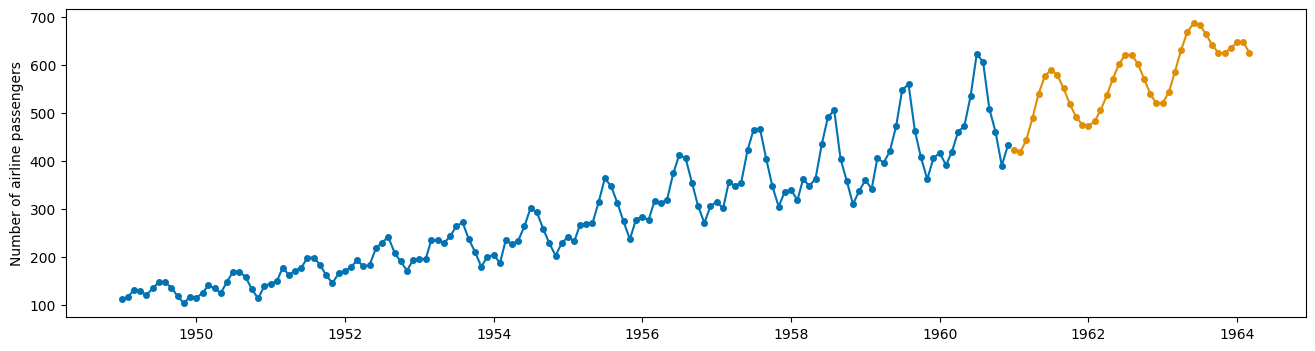

In [8]:
plot_series(y, preds)

If we try to forecast on a different horizon than the one passed during fit, we will run into runtime errors

In [9]:
# forecaster.predict(fh=[1, 2, 3])
# forecaster.predict(fh=[2, 5])
# forecaster.predict(fh=list(range(1, 50)))

Now, we will forecast multiple forecasting horizons using the same forecaster by wrapping that with AutoRegressiveWrapper

In [10]:
from sktime.forecasting.compose import AutoRegressiveWrapper

forecaster = PytorchForecastingNBeats(trainer_params={
    "max_epochs": 20,
})
wrapper = AutoRegressiveWrapper(forecaster, horizon_length=5)

In [11]:
wrapper.get_tag("requires-fh-in-fit")

False

In [ ]:
%%capture

wrapper.fit(y)
preds = wrapper.predict(fh=list(range(1, 40)))

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

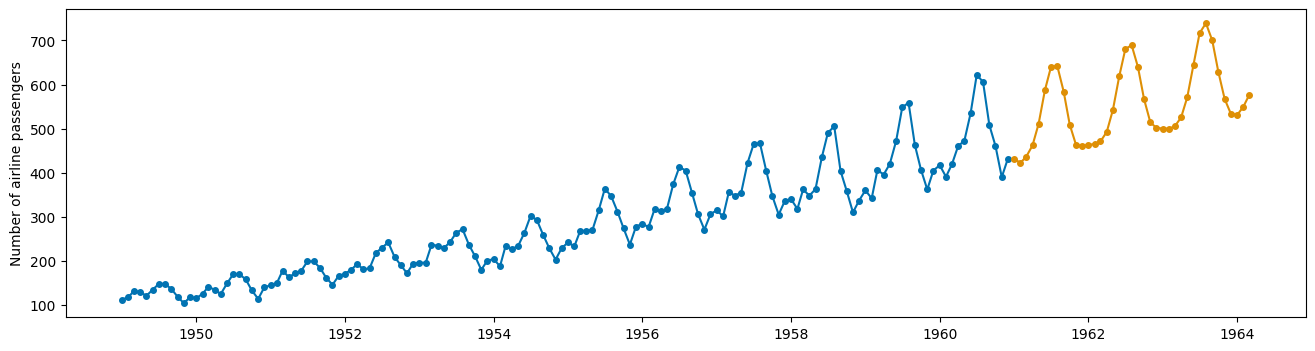

In [13]:
plot_series(y, preds)

the forecaster also predicts better when wrapped around the AutoRegressiveWrapper

similary we can forecast for other horizons as well that we could not do without AutoRegressiveWrapper

In [14]:
preds = wrapper.predict(fh=[1, 2, 3])
preds = wrapper.predict(fh=[2, 5])
preds = wrapper.predict(fh=list(range(1, 50)))

INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_ze

AutoRegressiveWrapper has global capability and works only with global forecasters

In [15]:
forecaster.get_class_tag("capability:global_forecasting")

True

In [16]:
wrapper.get_class_tag("capability:global_forecasting")

True

It also supports exogenous data if the inner forecaster supports so

In [17]:
wrapper.get_class_tag("ignores-exogeneous-X")

False

# LTSFTransformerForecaster

- **Title:** [ENH] De-Novo Implementation of LTSFTransformer Based on Cure-Lab Research Codebase
- **Status:** Merged
- **Pull Request:** [#6202](https://github.com/sktime/sktime/pull/6202)
- **Related Issue:** [#4939](https://github.com/sktime/sktime/issues/4939)
- **Research Paper:** [Are Transformers Effective for Time Series Forecasting?](https://ojs.aaai.org/index.php/AAAI/article/view/26317)
- **Official Code:** [cure-lab/LTSF-Linear](https://github.com/cure-lab/LTSF-Linear)
- **Sktime Source Code:** [sktime/forecasting/ltsf.py](https://github.com/sktime/sktime/blob/main/sktime/forecasting/ltsf.py)

This pull request introduces the `LTSFTransformer`, an implementation based on the paper "Are Transformers Effective for Time Series Forecasting?" which explores the application of transformer architecture to time series forecasting.

To begin the implementation, I structured the transformer architecture in the [sktime/networks/ltsf/layers](https://github.com/sktime/sktime/pull/6202/files#diff-0a18272d47c22fc6c495216fa5c757ee77153b9ddbc04daa00895a00ffa472a1) directory, along with the PyTorch dataset class [PytorchFormerDataset](https://github.com/sktime/sktime/pull/6202/files#diff-af8d474dbf509d241fd02bcc6071c7758ca194d93d3a9f1e3f25ebc8db1809ec).

Next, I developed the [`LTSFTransformerNetwork`](https://github.com/sktime/sktime/pull/6202/files#diff-598a15fdb2a333630aad06167788a7f9ec31eb46d4aae59687b0be38c872a7eb) interface class by leveraging the base PyTorch forecasting class, which connects to the network created in the previous step.

Throughout this implementation, I gained valuable insights into transformer architecture, particularly in applying various embeddings and encodings to temporal features in time series data.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

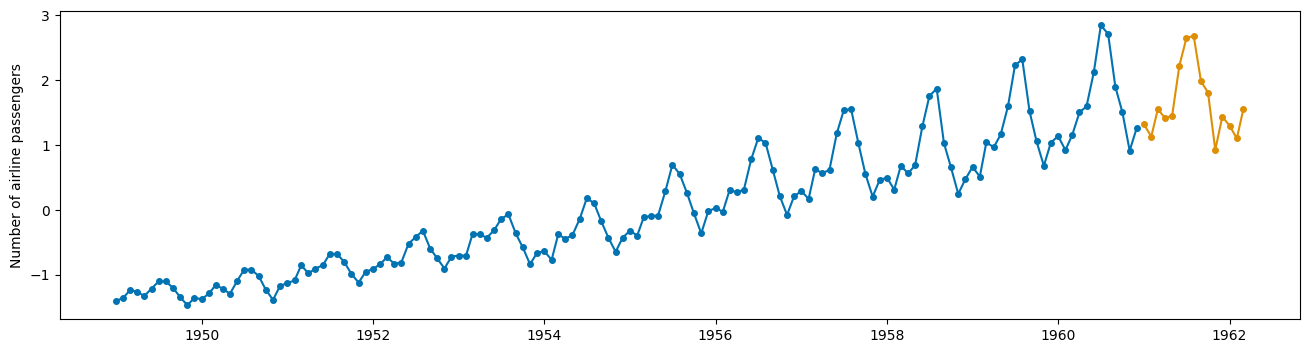

In [18]:
from sktime.forecasting.ltsf import LTSFTransformerForecaster

y = load_airline()

y = (y - y.mean()) / y.std()

model = LTSFTransformerForecaster(
	seq_len=30,
	context_len=15,
	pred_len=15,
    num_epochs=50,
    batch_size=8,
    in_channels=1,
    individual=False,
    criterion=None,
    criterion_kwargs=None,
    optimizer=None,
    optimizer_kwargs=None,
    lr=0.002,
    position_encoding=True,
    temporal_encoding=True,
    temporal_encoding_type="embed",  # linear, embed, fixed-embed
    d_model=32,
    n_heads=1,
    d_ff=64,
    e_layers=1,
    d_layers=1,
    factor=1,
    dropout=0.1,
    activation="relu",
    freq="M",
)

model.fit(y, fh=list(range(1, model.pred_len+1)))

preds = model.predict()
plot_series(y, preds)

In [19]:
model.get_class_tag("ignores-exogeneous-X")

True

# MVTSTransformerClassifier

- **Title:** [ENH] PyTorch Classifier & De-Novo Implementation of Transformer
- **Status:** Merged
- **Pull Request:** [#6791](https://github.com/sktime/sktime/pull/6791)
- **Related Issue:** [#6786](https://github.com/sktime/sktime/issues/6786)
- **Research Paper:** [A Transformer-based Framework for Multivariate Time Series Representation Learning](https://dl.acm.org/doi/abs/10.1145/3447548.3467401)
- **Official Code:** [gzerveas/mvts_transformer](https://github.com/gzerveas/mvts_transformer)
- **Sktime Source Code:** [sktime/classification/deep_learning/mvts_transformer.py](https://github.com/sktime/sktime/blob/main/sktime/classification/deep_learning/mvts_transformer.py)

This pull request introduces the `MVTSTransformerClassifier`, an implementation based on the paper "A Transformer-based Framework for Multivariate Time Series Representation Learning." The paper demonstrates how the MVTS (Multi-Variate Time Series) Transformer can be applied to classification and regression tasks.

In this PR, I implemented the [`BaseDeepClassifierPytorch`](https://github.com/sktime/sktime/pull/6791/files#diff-bbe6571ca91b7ba8297d9c19de41b7a86f201533bac9d307ea3a99781726841c) class, which serves as a foundation for building PyTorch-based deep neural networks for classification.

Next, I utilized the [`TSTransformerEncoderClassiregressor`](https://github.com/sktime/sktime/pull/6791/files#diff-8eef014681dea4cdf5c555aadf8e08ab1535f57de6b332ed7fa0e972272a609a) class, inspired by the mentioned research paper, to construct the PyTorch network.

Finally, I developed the [`MVTSTransformerClassifier`](https://github.com/sktime/sktime/pull/6791/files#diff-44b50f069a3c5c1dbf87bec02ac01fc5658391a07590f4bccf92cf6a2b5ec214) class, which connects the network class with the PyTorch base class, completing the estimator.

Throughout this process, I deepened my understanding of transformer architecture.

In [20]:
from sktime.classification.deep_learning import MVTSTransformerClassifier

model = MVTSTransformerClassifier(
    d_model=256,
    n_heads=4,
    num_layers=4,
    dim_feedforward=128,
    dropout=0.1,
    pos_encoding="fixed",
    activation="relu",
    norm="BatchNorm",
    freeze=False,
    num_epochs=30,
	verbose=False,
)

In [21]:
X_train, y_train = load_unit_test(split="train")
X_test, y_test = load_unit_test(split="test")

model.fit(X_train, y_train)
preds = model.predict(X_test)

preds, y_test

(array(['1', '1', '1', '1', '1', '1', '2', '1', '1', '1', '1', '1', '2',
        '2', '2', '2', '2', '1', '2', '2', '2', '2'], dtype='<U1'),
 array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2',
        '2', '2', '2', '2', '2', '2', '2', '2', '2'], dtype='<U1'))

In [22]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.9090909090909091

# TimesFMForecaster

- **Title:** [ENH] Interface to TimesFM Forecaster
- **Status:** Open
- **Pull Request:** [#6571](https://github.com/sktime/sktime/pull/6571)
- **Related Issue:** [#6408](https://github.com/sktime/sktime/issues/6408)
- **Research Paper:** [A Decoder-Only Foundation Model for Time-Series Forecasting](https://arxiv.org/abs/2310.10688)
- **Official Code:** [google-research/timesfm](https://github.com/google-research/timesfm)

TimesFM (Time Series Foundation Model) is a pre-trained model developed by Google Research, designed specifically for time-series forecasting.

While integrating this model into sktime, I encountered new libraries and packages. Due to dependency conflicts with the package available on PyPI, I forked the code to [sktime/libs/timesfm](https://github.com/sktime/sktime/pull/6571/files#diff-b64af953ed44337ca037cf681922b13563eff8208ea0fee96518d4f8b7d114b0).

I then created an interface for the model within the [`TimesFMForecaster`](https://github.com/sktime/sktime/pull/6571/files#diff-862938919a3ce54a64d3ff4f207d897e90e1d729b6c6cd52f2d9cfd9377808cc) class.

Throughout this implementation, I gained hands-on experience with foundation models and explored their capabilities.

In [23]:
y = load_airline()

In [24]:
from sktime.forecasting.timesfm_forecaster import TimesFMForecaster

forecaster = TimesFMForecaster(
    context_len=64,
    horizon_len=32,
)

In [ ]:
%%capture

forecaster.fit(y, fh=list(range(1, forecaster.horizon_len)))
y_pred = forecaster.predict()

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

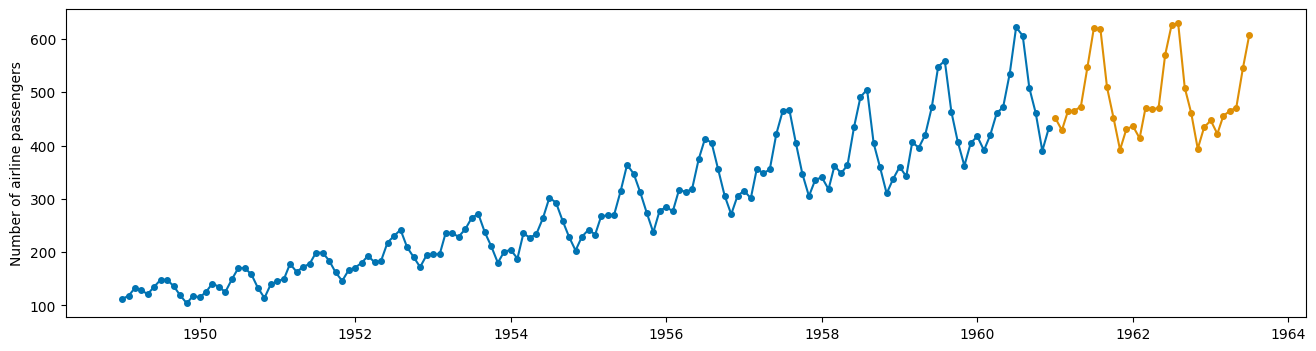

In [26]:
plot_series(y, y_pred)

`TimesFMForecaster` also supports Global Forecasting

In [28]:
forecaster.get_class_tag("capability:global_forecasting")

True

In [ ]:
%%capture

# Preparing the data
y = _make_hierarchical(
    hierarchy_levels=(2, 5), max_timepoints=100, min_timepoints=100, n_columns=1
)
y_train, y_test = train_test_split(
    y, test_size=0.1, shuffle=False
)
y_test = y_test.groupby(level=0).apply(
    lambda x: x.droplevel(0).iloc[:-4]
)

# Loading the model
forecaster = TimesFMForecaster(
    context_len=64,
    horizon_len=32,
)

# fit and forecast
forecaster.fit(y_train, fh=[1, 2, 3, 4])
preds = forecaster.predict(y=y_test)

In [30]:
preds

c0
h0   h1   time                
h0_1 h1_4 2000-04-06  4.485561
          2000-04-07  4.447956
          2000-04-08  4.479393
          2000-04-09  4.502285

# TinyTimeMixerForecaster

- **Title:** [ENH] Interface to TinyTimeMixer Foundation Model
- **Status:** Merged
- **Pull Request:** [#6712](https://github.com/sktime/sktime/pull/6712)
- **Related Issue:** [#6698](https://github.com/sktime/sktime/issues/6698)
- **Research Paper:** [Tiny Time Mixers (TTMs): Fast Pre-trained Models for Enhanced Zero/Few-Shot Forecasting of Multivariate Time Series](https://www.researchgate.net/profile/Vijay-Ekambaram/publication/381111250_Tiny_Time_Mixers_TTMs_Fast_Pre-trained_Models_for_Enhanced_ZeroFew-Shot_Forecasting_of_Multivariate_Time_Series/links/665d8c5d0b0d2845747de5f5/Tiny-Time-Mixers-TTMs-Fast-Pre-trained-Models-for-Enhanced-Zero-Few-Shot-Forecasting-of-Multivariate-Time-Series.pdf)
- **Official Code:** [ibm-granite/granite-tsfm](https://github.com/ibm-granite/granite-tsfm)
- **Sktime Source Code:** [sktime/forecasting/ttm.py](https://github.com/sktime/sktime/blob/main/sktime/forecasting/ttm.py)

TinyTimeMixer (TTM) is a compact, pre-trained model for time-series forecasting, developed and open-sourced by IBM Research.

In this PR, I integrated TTM into the sktime framework by forking the official code into the [sktime/libs/granite_ttm](https://github.com/sktime/sktime/pull/6712/files#diff-b3059a73c53cb90d9ba1a01f34ded57098aa285d85d170320011e39474fc4ca9) directory, as the source package was not available on PyPI.

Next, I developed an interface for the estimator within the [`TinyTimeMixerForecaster`](https://github.com/sktime/sktime/pull/6712/files#diff-0a25dac16832f47a85e6d03327d4270510efa529cf0e42e1fc71786dde192711) class.

Throughout this implementation, I gained valuable experience in creating custom Hugging Face models and configurations, loading and modifying weights, altering architecture, and training newly initialized weights.

In [31]:
from sktime.forecasting.ttm import TinyTimeMixerForecaster

y = load_airline()

model = TinyTimeMixerForecaster(
    config={
        "context_length": 20,
        "prediction_length": 10,
    },
    training_args={
        "num_train_epochs": 100,
        "output_dir": "test_output",
        "per_device_train_batch_size": 32,
        "report_to": "none",
        "learning_rate": 1e-2,
    },
)

In [ ]:
%%capture

model.fit(y, fh=list(range(1, 11)))
preds = model.predict()

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

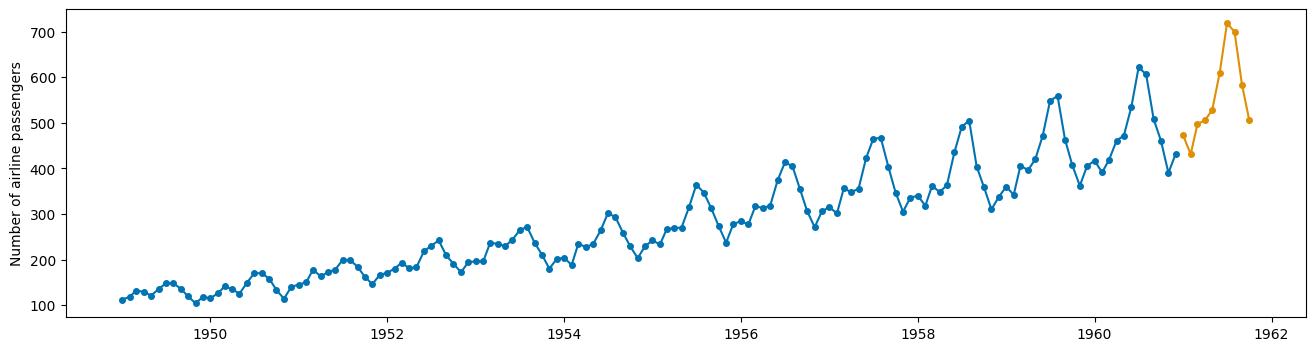

In [33]:
plot_series(y, preds)

`TinyTimeMixerForecaster` also supports Global Forecasting

In [34]:
forecaster.get_class_tag("capability:global_forecasting")

True

In [ ]:
%%capture

# Preparing the data
y = _make_hierarchical(
    hierarchy_levels=(2, 5), max_timepoints=100, min_timepoints=100, n_columns=2
)
y_train, y_test = train_test_split(
    y, test_size=0.1, shuffle=False
)
y_test = y_test.groupby(level=0).apply(
    lambda x: x.droplevel(0).iloc[:-4]
)

# Loading the model
model = TinyTimeMixerForecaster(
    config={
        "context_length": 20,
        "prediction_length": 10,
    },
    training_args={
        "num_train_epochs": 1,
        "output_dir": "test_output",
        "per_device_train_batch_size": 32,
        "report_to": "none",
        "learning_rate": 1e-2,
    },
	broadcasting=False,
)

# fit and forecast
model.fit(y_train, fh=[1, 2, 3, 4])
preds = model.predict(y=y_test)

In [36]:
preds

c0        c1
h0   h1   time                          
h0_1 h1_4 2000-04-06  4.120028  4.049014
          2000-04-07  4.238961  4.212027
          2000-04-08  4.158207  4.146166
          2000-04-09  4.054813  4.178536